# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [1]:
name = 'Elena Vasileva'
if name == '':
    raise NotImplementedError('Elena Vasileva')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [2]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests 
        import unittest
        import networkx as nx
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [3]:
import requests
from bs4 import BeautifulSoup
import re

def get_all_links(url: str):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        links = [a['href'] for a in soup.find_all('a', href=True) if re.match(r'^https?://', a['href'])]
        return links
    except requests.exceptions.RequestException as e:
        print(f"error in getting URL {url}: {e}")
        return []

In [4]:
def test_get_all_links():
    links = get_all_links('http://example.com')
    assert isinstance(links, list), "awaiting a list as e result"
    
    links = get_all_links('invalid_url')
    assert links == [], "invalid url returns an empty list"
    
    links = get_all_links('https://www.google.com/search?q=test')
    assert isinstance(links, list), "awaiting a list as a result (even without links)"

if __name__ == "__main__":
    test_get_all_links()


error in getting URL invalid_url: Invalid URL 'invalid_url': No scheme supplied. Perhaps you meant https://invalid_url?


In [5]:
get_all_links('http://en.wikipedia.com')[:10]

['https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sidebar&wmf_campaign=en.wikipedia.org&uselang=en',
 'https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sidebar&wmf_campaign=en.wikipedia.org&uselang=en',
 'https://commons.wikimedia.org/wiki/Main_Page',
 'https://foundation.wikimedia.org/wiki/Home',
 'https://www.mediawiki.org/wiki/MediaWiki',
 'https://meta.wikimedia.org/wiki/Main_Page',
 'https://outreach.wikimedia.org/wiki/Main_Page',
 'https://wikisource.org/wiki/Main_Page',
 'https://species.wikimedia.org/wiki/Main_Page',
 'https://en.wikibooks.org/wiki/Main_Page']

## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [6]:
def get_neighbor_pages(url: str):
    links = get_all_links(url)
    for link in links:
        try:
            response = requests.get(link, timeout=10)
            response.raise_for_status()
            yield response.text
        except requests.exceptions.RequestException as e:
            print(f"error in getting link {link}: {e}")
            yield None

In [7]:
def test_get_neighbor_pages():
    generator = get_neighbor_pages('http://example.com')
    for content in generator:
        assert content is not None
        assert isinstance(content, str) or content is None

    generator = get_neighbor_pages('invalid_url')
    assert list(generator) == []

if __name__ == "__main__":
    test_get_neighbor_pages()
    for html in get_neighbor_pages('http://en.wikipedia.com'):
        print(html[:100])

error in getting URL invalid_url: Invalid URL 'invalid_url': No scheme supplied. Perhaps you meant https://invalid_url?
<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8">
<title>
<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8">
<title>
<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8">
<title>
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-la
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-disabled vector-feature-l
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-la
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-la
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-la
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-head

## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

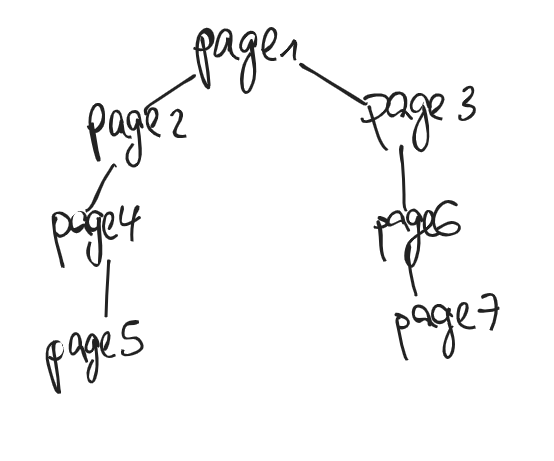

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [8]:
def get_pages_depth(url: str, depth: int):
    visited = set()
    def traverse(url, current_depth):
        if current_depth > depth or url in visited:
            return
        visited.add(url)
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            yield response.text
            links = get_all_links(url)
            for link in links:
                yield from traverse(link, current_depth + 1)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching URL {url}: {e}")
    yield from traverse(url, 0)

In [9]:
def test_get_pages_depth():
    generator = get_pages_depth('http://example.com', 1)
    pages = list(generator)
    assert len(pages) > 0
    assert all(isinstance(page, str) for page in pages)

    generator = get_pages_depth('invalid_url', 1)
    assert list(generator) == []

In [10]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [11]:
next(pages)

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-not-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Wikipedia, the free encyclopedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-di

## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [154]:
import requests
from bs4 import BeautifulSoup
import random

In [155]:
WIKIPREDIA_URL = "https://en.wikipedia.org/"

In [156]:
def get_scientists_links(subpage_url: str) -> list[tuple[str, str]]:
    url = WIKIPREDIA_URL + subpage_url
    response = requests.get(url, timeout=10)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')
    result = []
    for li in soup.find_all("li"):
        cls = li.get("class")
        if not cls:
            a_list = li.findAll("a")
            if a_list:
                if a_list[0].get("title"):
                    href = a_list[0].get("href")
                    if href == "/wiki/List_of_computing_people":
                        break
                    result.append((a_list[0].text, WIKIPREDIA_URL + href[1:]))
    return result

In [157]:
def parse_vcard(full_link: str) -> dict[str, str]:
    response = requests.get(full_link, timeout=10)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all("table")
    if len(tables) == 0:
        return None
    for table in tables:
        if table.get("class") == ['infobox', 'biography', 'vcard']:
            break
    tbody = table.find_all("tbody")[0]
    result = {}
    for tr in tbody.find_all("tr"):
        children = list(tr.children)
        if children:
            if children[0].get("class") == ['infobox-label']:
                text = children[0].text
                data = children[1].text
                result[text] = data

    return result

In [158]:
class ComputerScientist:
    def __init__(self, name, birthdate=None, major_achievements=None, alma_mater=None):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements
        self.alma_mater = alma_mater

    def __repr__(self):
        return (f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, "
                f"major_achievements={self.major_achievements}, alma_mater={self.alma_mater})")

In [159]:
links = get_scientists_links("wiki/List_of_computer_scientists")
random.shuffle(links)
links = links[:100]

In [165]:
MAPPING = {
    "Born": "birthdate",
    'Alma\xa0mater': "alma_mater",
    "Known\xa0for": "major_achievements",
}

def remap_keys(dict_: dict[str, str]):
    result = {}
    for k, v in dict_.items():
        if k in MAPPING:
            remapped = MAPPING[k]
            if remapped == "major_achievements":
                v = v.split("\n")
            result[remapped] = v
    return result

In [166]:
scientists = []
for name, link in links:
    dict_ = parse_vcard(link)
    if dict_:
        dict_ = remap_keys(dict_)
        scientists.append(ComputerScientist(name, **dict_))

In [167]:
for s in scientists:
    print(s)

ComputerScientist(name=Ian Goldberg, birthdate= (1973-03-31) March 31, 1973 (age 51), major_achievements=['Off-the-Record Messaging'], alma_mater=University of California, Berkeley (M.Sc., Ph.D.)University of Waterloo (B.Math))
ComputerScientist(name=Brendan Eich, birthdate= (1961-07-04) July 4, 1961 (age 63)Pittsburgh, Pennsylvania, US, major_achievements=['Creation of JavaScript and co-founder of Mozilla project, Mozilla Foundation, and Mozilla Corporation'], alma_mater=University of Illinois Urbana-ChampaignSanta Clara University)
ComputerScientist(name=Reinder van de Riet, birthdate=(1939-04-22)22 April 1939Groningen, Netherlands, major_achievements=['Editor, Europe of Data and Knowledge EngineeringCOLOR-X event modeling language'], alma_mater=None)
ComputerScientist(name=Aaron Sloman, birthdate=1936 (age 88–89)Zimbabwe, major_achievements=None, alma_mater=None)
ComputerScientist(name=Jordi Ustrell Aguilà, birthdate= (1955-08-03) August 3, 1955 (age 69)Barcelona, Spain, major_achie

# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [178]:
def fetch_scientist(name):
    name2link = {k: v for k, v in get_scientists_links("wiki/List_of_computer_scientists")}
    if name in name2link:
        link = name2link[name]
        dict_ = parse_vcard(link)
        if dict_:
            dict_ = remap_keys(dict_)
            return ComputerScientist(name, **dict_)
        else:
            print("sorry invalid page schema")
    else:
        print("sorry cannot find")
    return None


In [179]:
fetch_scientist("Lotfi Zadeh")

ComputerScientist(name=Lotfi Zadeh, birthdate=Lotfi Aliaskerzadeh(1921-02-04)4 February 1921Baku, Azerbaijan Soviet Socialist Republic, major_achievements=['Founder of fuzzy mathematics,  fuzzy set theory, and fuzzy logic, Z numbers, Z-transform'], alma_mater=University of TehranMassachusetts Institute of TechnologyColumbia University)

# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.